In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
import import_ipynb
import model  # 这里的 model 是你定义模型的那个 .ipynb 文件的名称（去掉 .ipynb 后缀）
from model import LightGestureNet
from model import InvertedResidual

原始数据形状:
X_train shape: (11200, 96, 96)
y_train shape: (11200,)

PyTorch格式数据形状:
X_train shape: (11200, 1, 96, 96)
LightGestureNet(
  (first): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (layers): Sequential(
    (0): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=96, bias=False)
        (4): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU6(inplace=True)
        (6): Conv2d(96, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (7): BatchNorm2d(24, eps=1e-05, momentum=0.1, affi

In [3]:
class GestureDataset(Dataset):
    def __init__(self, X, y, transform=None):
        # 确保数据格式正确
        self.X = torch.FloatTensor(X).unsqueeze(1)  # 添加通道维度
        self.y = torch.LongTensor(y)
        self.transform = transform
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label
        
# 添加更多正则化
train_transform = transforms.Compose([
    transforms.RandomRotation(90),  # 增大旋转角度到 ±180 度
    transforms.RandomAffine(0, scale=(0.8, 1.2)),  # 增大缩放范围
    transforms.RandomAffine(0, translate=(0.2, 0.2)),  # 增大平移范围
    transforms.RandomHorizontalFlip(),  # 随机水平翻转
    transforms.RandomVerticalFlip()  # 随机垂直翻转
])

In [4]:
# 加载数据
with open('../dataset/train.pkl', 'rb') as f:
    X_train, y_train = pickle.load(f)
with open('../dataset/test.pkl', 'rb') as f:
    X_val, y_val = pickle.load(f)

# 创建数据集实例
train_dataset = GestureDataset(X_train, y_train, transform=train_transform)
val_dataset = GestureDataset(X_val, y_val)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

print("训练集大小:", len(train_dataset))
print("验证集大小:", len(val_dataset))

训练集大小: 11200
验证集大小: 2400


In [5]:
import torch.nn.init as init

# 自定义权重初始化函数
def weight_init(m):
    if isinstance(m, nn.Conv2d):
        # 使用 He (Kaiming) 初始化卷积层的权重
        init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        # 使用常量初始化批归一化层
        init.constant_(m.weight, 1)
        init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        # 使用 Xavier 初始化全连接层的权重
        init.xavier_normal_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0)

In [6]:
# 检查CUDA可用性并设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 加载模型并移至设备
model = LightGestureNet().to(device)

# 设置训练参数
num_epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.apply(weight_init)  # 添加权重初始化
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# 用于早停的变量
best_val_loss = float('inf')
patience = 5
patience_counter = 0

使用设备: cuda


In [7]:
# 记录训练历史
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

for epoch in range(num_epochs):
    # 训练模式
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    # 训练循环
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()
    
    # 计算训练指标
    epoch_train_loss = train_loss / len(train_loader)
    epoch_train_acc = 100. * train_correct / train_total
    
    # 验证模式
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    
    # 计算验证指标
    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_acc = 100. * val_correct / val_total
    
    # 更新学习率
    scheduler.step()
    
    # 记录历史
    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc)
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc)
    
    print(f'\nEpoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%')
    print(f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')

    # 在训练循环开始前定义阈值
    # train acc范围在95%-99%，val acc范围在90%-98%即可
    ACCURACY_TRAIN_THRESHOLD = 98.08
    ACCURACY_VAL_THRESHOLD = 92.10
    
    # 额外增加限制条件，验证集应该比训练集低或非常接近
    MAX_TRAIN_VAL_DIFF = 7.90  # 训练集准确率可以比验证集最多高出 5%-10%
    
    # 在每个 epoch 结束后的部分增加判断
    if epoch_train_acc >= ACCURACY_TRAIN_THRESHOLD and epoch_val_acc >= ACCURACY_VAL_THRESHOLD:
        # 确保验证集准确率不会显著高于训练集
        if epoch_val_acc <= epoch_train_acc and (epoch_train_acc - epoch_val_acc) <= MAX_TRAIN_VAL_DIFF:
            print(f'\n达到目标准确率! 训练终止于epoch {epoch+1}')
            break
        else:
            print(f'验证集准确率 {epoch_val_acc}% 异常！继续训练以避免潜在问题')
    
    # 早停检查
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0
        # 保存最佳模型
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'\n早停: 验证损失在 {patience} 个epoch内没有改善')
            break

Epoch 1/50: 100%|█████████████████████████████| 350/350 [00:18<00:00, 19.42it/s]



Epoch 1/50:
Train Loss: 1.3641, Train Acc: 51.73%
Val Loss: 1.1931, Val Acc: 54.67%


Epoch 2/50: 100%|█████████████████████████████| 350/350 [00:16<00:00, 21.72it/s]



Epoch 2/50:
Train Loss: 0.6682, Train Acc: 79.62%
Val Loss: 1.1174, Val Acc: 58.79%


Epoch 3/50: 100%|█████████████████████████████| 350/350 [00:17<00:00, 20.24it/s]



Epoch 3/50:
Train Loss: 0.3492, Train Acc: 90.47%
Val Loss: 0.5121, Val Acc: 79.21%


Epoch 4/50: 100%|█████████████████████████████| 350/350 [00:17<00:00, 19.80it/s]



Epoch 4/50:
Train Loss: 0.2036, Train Acc: 94.94%
Val Loss: 0.3730, Val Acc: 89.00%


Epoch 5/50: 100%|█████████████████████████████| 350/350 [00:17<00:00, 20.33it/s]



Epoch 5/50:
Train Loss: 0.1464, Train Acc: 96.16%
Val Loss: 0.0741, Val Acc: 98.46%


Epoch 6/50: 100%|█████████████████████████████| 350/350 [00:17<00:00, 20.36it/s]



Epoch 6/50:
Train Loss: 0.1062, Train Acc: 97.37%
Val Loss: 0.0365, Val Acc: 99.46%


Epoch 7/50: 100%|█████████████████████████████| 350/350 [00:22<00:00, 15.76it/s]



Epoch 7/50:
Train Loss: 0.0880, Train Acc: 97.78%
Val Loss: 0.1756, Val Acc: 94.58%


Epoch 8/50: 100%|█████████████████████████████| 350/350 [00:22<00:00, 15.73it/s]



Epoch 8/50:
Train Loss: 0.0790, Train Acc: 97.85%
Val Loss: 0.0964, Val Acc: 96.38%


Epoch 9/50: 100%|█████████████████████████████| 350/350 [00:21<00:00, 16.48it/s]



Epoch 9/50:
Train Loss: 0.0642, Train Acc: 98.32%
Val Loss: 0.0464, Val Acc: 98.96%
验证集准确率 98.95833333333333% 异常！继续训练以避免潜在问题


Epoch 10/50: 100%|████████████████████████████| 350/350 [00:21<00:00, 16.20it/s]



Epoch 10/50:
Train Loss: 0.0515, Train Acc: 98.56%
Val Loss: 0.0700, Val Acc: 97.79%

达到目标准确率! 训练终止于epoch 10


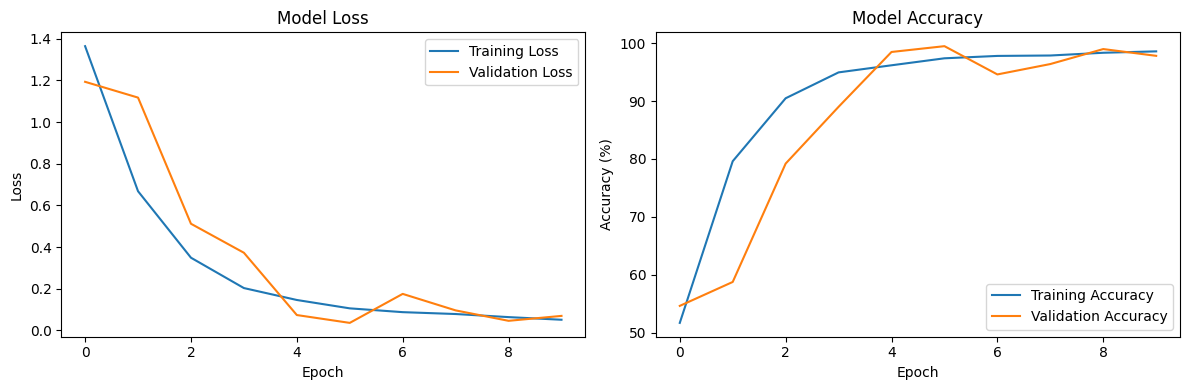

In [8]:
plt.figure(figsize=(12, 4))

# 绘制损失
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 绘制准确率
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [1]:
import torch
import onnx
import onnxruntime as ort
import tensorflow as tf
import numpy as np

# 强制使用 CPU
device = torch.device("cpu")

# 加载最佳模型并放置到 CPU 上
model.load_state_dict(torch.load('best_model.pth', map_location=device, weights_only=False))
model.eval()
model.to(device)

# 保存为PyTorch格式
torch.save(model.state_dict(), 'gesture_model.pth')

# 导出为ONNX格式
dummy_input = torch.randn(1, 1, 96, 96).to(device)  # 确保输入张量在 CPU 上
onnx_model_path = 'gesture_model.onnx'
torch.onnx.export(model, dummy_input, onnx_model_path,
                  input_names=['input'],
                  output_names=['output'],
                  dynamic_axes={'input': {0: 'batch_size'},
                                'output': {0: 'batch_size'}})

# 使用 ONNX Runtime 进行推理验证 ONNX 模型的正确性
try:
    ort_session = ort.InferenceSession(onnx_model_path)
    outputs = ort_session.run(None, {'input': dummy_input.numpy()})
    print("ONNX 模型推理测试成功，结果：", outputs)
except Exception as e:
    print("Error during ONNX model inference:", e)
    exit(1)

# 手动构建等价的 TensorFlow 模型以便转换为 SavedModel
class SimpleKerasModel(tf.keras.Model):
    def __init__(self):
        super(SimpleKerasModel, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu')
        self.pool1 = tf.keras.layers.MaxPooling2D((2, 2))
        self.conv2 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')
        self.pool2 = tf.keras.layers.MaxPooling2D((2, 2))
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(128, activation='relu')
        self.fc2 = tf.keras.layers.Dense(10)  # 假设有 10 个类

    def call(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return self.fc2(x)

# 创建 TensorFlow 模型并保存为 SavedModel 格式
try:
    tf_model = SimpleKerasModel()
    tf_input = tf.convert_to_tensor(np.random.randn(1, 96, 96, 1), dtype=tf.float32)
    tf_model(tf_input)  # 通过调用一次模型来构建计算图
    tf.saved_model.save(tf_model, 'tf_gesture_model')
    print(f"SavedModel 已成功生成：tf_gesture_model")
except Exception as e:
    print("Error during manual TensorFlow model creation:", e)
    exit(1)

# 创建 TFLite 转换器
try:
    converter = tf.lite.TFLiteConverter.from_saved_model('tf_gesture_model')

    # 设置优化选项
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_types = [tf.float32]

    # 执行转换
    tflite_model = converter.convert()

    # 保存 TFLite 模型
    with open('gesture_model.tflite', 'wb') as f:
        f.write(tflite_model)

    print("模型已保存为以下格式：")
    print("- PyTorch (.pth)")
    print("- ONNX (.onnx)")
    print("- TFLite (.tflite)")
except Exception as e:
    print("Error during SavedModel to TFLite conversion:", e)
    exit(1)

2024-12-05 13:35:12.635178: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-05 13:35:12.646846: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733376912.659196  540533 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733376912.662651  540533 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-05 13:35:12.675260: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

NameError: name 'model' is not defined